## Setup

In [19]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import numpy as np
import pickle
from sklearn import model_selection, svm
from matplotlib import pyplot as plt

## Pipe the dataset to a model

In [2]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_train_preprocessed = X_train / 128
X_train_preprocessed -= 1
print("X_train_preprocessed.shape:", X_train_preprocessed.shape)
print("y_train.shape:", y_train.shape)

number_of_images = y_train.size
print("number_of_images:", number_of_images)

X_train_preprocessed.shape: (5913, 224, 224, 3)
y_train.shape: (5913,)
number_of_images: 5913


In [3]:
inception_v3 = InceptionV3(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

# let's visualize layer names and layer indices to see which layer we want to extract features from
for i, layer in enumerate(inception_v3.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [4]:
# let's use the output of the last activation after the second to last set of conv2d layers
model = Model(inputs=inception_v3.input, outputs=inception_v3.layers[288].output)

# let's extract features from each of the images
features = np.array([model.predict(np.expand_dims(X_train_preprocessed[i], axis=0)) for i in range(number_of_images)])
print("features.shape:", features.shape)
print("features:", features)

features.shape: (5913, 1, 5, 5, 384)
features: [[[[[7.00290322e-01 2.01626837e-01 0.00000000e+00 ... 7.44248033e-02
     2.35960305e-01 0.00000000e+00]
    [4.20005500e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     0.00000000e+00 0.00000000e+00]
    [1.49786174e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     5.72811365e-02 0.00000000e+00]
    [3.32422495e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     4.52281237e-02 0.00000000e+00]
    [5.12453020e-01 3.55839252e-01 0.00000000e+00 ... 0.00000000e+00
     2.69712687e-01 0.00000000e+00]]

   [[6.51007593e-01 2.35083103e-02 0.00000000e+00 ... 3.28733325e-02
     2.34490335e-01 0.00000000e+00]
    [4.02389526e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     1.18586302e-01 0.00000000e+00]
    [1.91162258e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     2.45160222e-01 0.00000000e+00]
    [3.56954575e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
     2.09786057e-01 0.00000000e+00]
    [5

In [7]:
pickle.dump(features, open("features_inception_v3_layer_288.pkl", "wb"))

In [11]:
features_inception_v3_layer_288 = pickle.load(open("features_inception_v3_layer_288.pkl", "rb"))
print("features_inception_v3_layer_288.shape", features_inception_v3_layer_288.shape)
features_inception_v3_layer_288_flattened = np.array([features_inception_v3_layer_288[i].flatten() for i in range(number_of_images)])
print("features_inception_v3_layer_288_flattened.shape", features_inception_v3_layer_288_flattened.shape)

features_inception_v3_layer_288.shape (5913, 1, 5, 5, 384)
features_inception_v3_layer_288_flattened.shape (5913, 9600)


In [16]:
def generate_validation_curve(estimator, X, y, param_name, param_range,
    scoring, n_jobs, title, xlabel):

    train_scores, test_scores = model_selection.validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        scoring=scoring, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training accuracy",
               color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                   train_scores_mean + train_scores_std, alpha=0.2,
                   color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation accuracy",
               color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                   test_scores_mean + test_scores_std, alpha=0.2,
                   color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

/usr/local/google/home/jatron/personal/structural-damage-recognition/my_virtual_env/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


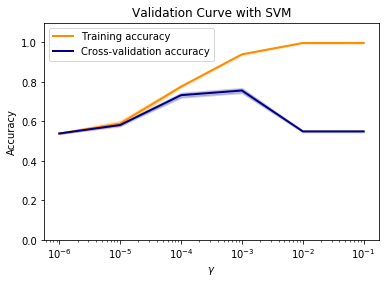

In [20]:
param_range = np.logspace(-6, -1, 6)

# uses the default 3-fold cross validation
generate_validation_curve(svm.SVC(), features_inception_v3_layer_288_flattened, y_train, param_name="gamma",
                                param_range=param_range, scoring="accuracy", n_jobs=-1,
                                title="Validation Curve with SVM", xlabel="$\gamma$")